## EAEEE4000_001_Final Project_Third Model Code --- Using LSTM
#### Name: Jiuhe(Rebecca) Shi (UNI: js6112)
#### Project Title: Prediction of Ocen Partial Pressure of CO2 (pCO2)  by Using XGBoost, Random Forest and LSTM
#### Date: December, 2022

### LSTM Background

Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data (such as speech or video). 

The name of LSTM refers to the analogy that a standard RNN has both "long-term memory" and "short-term memory". The connection weights and biases in the network change once per episode of training, analogous to how physiological changes in synaptic strengths store long-term memories; the activation patterns in the network change once per time-step, analogous to how the moment-to-moment change in electric firing patterns in the brain store short-term memories. The LSTM architecture aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory".

Reference - [`LSTM` ](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).
![RF](images/LSTM_Principle.jpg)

### Load all packages used in this project

In [1]:
# packages used in this tutorial 
import xarray as xr
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow.keras.models import Model, load_model
from matplotlib import pyplot
from datetime import datetime
# LSTM Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Evaluation metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# pretreatment of data in time series, also with scale
from lstm_utils import get_lstm_data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Open & Clean Dataset 

In [2]:
data = xr.open_dataset('/Users/rebecca/Downloads/MERGED-DATA_1x1_mon_198201-202112.nc')
data = data.sel(time=slice('1982', '2021')).load()
data_pd = data.to_dataframe()

In [3]:
data_clean = data_pd.dropna()
data_clean

fco2_ave_unwtd         mld       chl  mask        sss  \
time       lat   lon                                                            
1982-01-15 -0.5  137.5      320.476288   34.367130  0.213072   1.0  34.227975   
            0.5  137.5      336.389130   33.478939  0.130572   1.0  34.261681   
            1.5  137.5      342.459686   39.543957  0.126997   1.0  34.302076   
            2.5  136.5      343.751190   23.772850  0.133725   1.0  34.300365   
                 137.5      344.493958   45.244648  0.128011   1.0  34.309180   
...                                ...         ...       ...   ...        ...   
2021-12-15  44.5 334.5      377.762512  129.950058  0.180022   1.0  35.823172   
                 341.5      382.966675  109.925339  0.469160   1.0  35.762420   
                 342.5      386.497375   84.819145  0.402202   1.0  35.757088   
            45.5 348.5      395.024994  102.078323  0.617956   1.0  35.662514   
            46.5 350.5      396.402771  100.040131  0.241002   1.0  35.623573   

                              sst  atm_pco2_uatm  
time       lat   lon                              
1982-01-15 -0.5  137.5  29.022418     331.245001  
            0.5  137.5  29.269918     331.245001  
            1.5  137.5  29.666697     331.245001  
            2.5  136.5  29.420000     331.245001  
                 137.5  29.702498     331.245001  
...                           ...            ...  
2021-12-15  44.5 334.5  16.412507     404.900235  
                 341.5  15.100598     404.900235  
                 342.5  15.084283     404.900235  
            45.5 348.5  14.092825     404.900235  
            46.5 350.5  13.716935     404.900235  

[252850 rows x 7 columns]

### Split Data into Training and Testing 

In [4]:
# Fetching time-series data
X, Y = get_lstm_data(data_pd, 10, scale=False)
print(X.shape, Y.shape)

# Split the Data for training and testing
X_t, Y_t =  X[:227565,:,:],  Y[:227565,:,:]

X_te, Y_te =  X[227565:,:,:],  Y[227565:,:,:]

print("X Train data size: {} and Y Train data size: {}".format(X_t.shape, Y_t.shape))
print("X Test data size: {} and Y Test data size: {}".format(X_te.shape, Y_te.shape))

(252850, 10, 6) (252850, 10, 1)
X Train data size: (227565, 10, 6) and Y Train data size: (227565, 10, 1)
X Test data size: (25285, 10, 6) and Y Test data size: (25285, 10, 1)


In [5]:
# Slicing the data 
X_train = X_t
Y_train = Y_t[:,-1,:]
print(X_train.shape, Y_train.shape)

X_test = X_te
Y_test = Y_te[:,-1,:]
print(X_test.shape, Y_test.shape)

(227565, 10, 6) (227565, 1)
(25285, 10, 6) (25285, 1)


###  LSTM model Building and Training

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 20
learning_rate  = 0.01
minibatch_size = 64

In [7]:
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]))

lstm_1 = tf.keras.layers.LSTM(64, return_sequences=True, activation=activation)(input_layer)
lstm_2 = tf.keras.layers.LSTM(64, return_sequences=False, activation=activation)(lstm_1)
# lstm_3 = tf.keras.layers.LSTM(n_neuron, return_sequences=False, activation=activation)(lstm_2)

dense_1 = tf.keras.layers.Dense(n_neuron, activation=activation)(lstm_2)
dense_2 = tf.keras.layers.Dense(Y_train.shape[-1], activation='linear')(dense_1)

model = Model(inputs=input_layer, outputs=dense_2)
model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 55,425
Trainable params: 55,425
Non-trainable params: 0
_________________________________________________________________


2022-12-23 16:40:37.077619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Best model save name definition
now = datetime.now()
best_model = "best_model/lstm_best_model-{}.h5".format(now.strftime("%d-%m-%Y-%H:%M:%S"))

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model, monitor='loss', 
                                                verbose=True, save_best_only=True, save_weights_only=True)
start = time.time()
history = model.fit(X_train, Y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.1, verbose=1,
                        callbacks=[early_stop, checkpoint],
                        shuffle=False)
print ("Training time: {}".format(time.time() - start))

Epoch 1/20
3197/3201 [============================>.] - ETA: 0s - loss: 2615.7983
Epoch 1: loss improved from inf to 2614.46387, saving model to best_model/lstm_best_model-23-12-2022-16:40:37.h5
3201/3201 [==============================] - 33s 10ms/step - loss: 2614.4639 - val_loss: 649.7983
Epoch 2/20
3197/3201 [============================>.] - ETA: 0s - loss: 1096.0338
Epoch 2: loss improved from 2614.46387 to 1095.19946, saving model to best_model/lstm_best_model-23-12-2022-16:40:37.h5
3201/3201 [==============================] - 31s 10ms/step - loss: 1095.1995 - val_loss: 1502.2388
Epoch 3/20
3201/3201 [==============================] - ETA: 0s - loss: 1001.2007
Epoch 3: loss improved from 1095.19946 to 1001.20074, saving model to best_model/lstm_best_model-23-12-2022-16:40:37.h5
3201/3201 [==============================] - 31s 10ms/step - loss: 1001.2007 - val_loss: 188.4173
Epoch 4/20
3200/3201 [============================>.] - ETA: 0s - loss: 330.8163
Epoch 4: loss improved fr

### Loss Value of LSTM

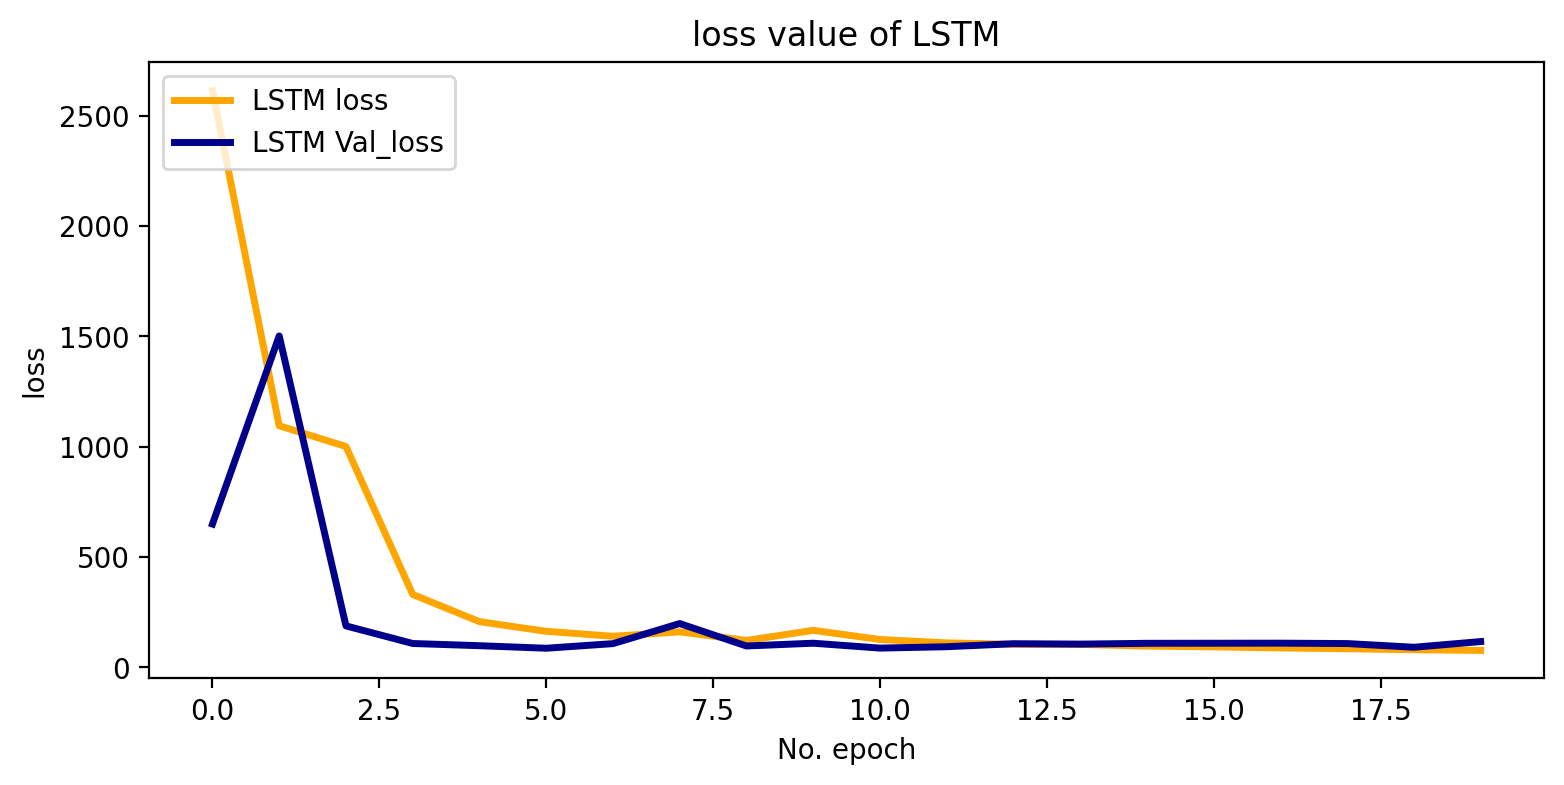

In [10]:
# plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(9, 4))
plt.plot(history.history['loss'], 'orange', linewidth=2.5, label='LSTM loss')
plt.plot(history.history['val_loss'], 'darkblue', linewidth=2.5, label='LSTM Val_loss')
plt.title('loss value of LSTM')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

### Relationship Between Predicted Values & True Values 

In [11]:
print(Y_train.shape)
print(Y_pred)
print(data_clean.atm_pco2_uatm.values.shape)

(227565, 1)


NameError: name 'Y_pred' is not defined

### Y_train vs. Y_pred_train

In [ ]:
Y_pred_train = model.predict(X_train)

In [ ]:
plt.figure(figsize=(9, 4))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
plt.plot(Y_train, 'orange', label='Training data')
plt.plot(Y_pred_train, 'darkblue', label='Predicted data')
# plt.plot(data_clean.atm_pco2_uatm.values, 'r--', label='pd data')

# plt.plot(Y_test, 'r--', linewidth=2.5, label='Test data')
plt.title("pCO2 Value")
plt.legend()
plt.show()

### Y_test vs. Y_pred_test

In [ ]:
Y_pred_test = model.predict(X_test)

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(Y_pred[:,1], label='q_predicted')
# plt.plot(Y_train[:,1], label='q')
plt.plot(Y_test, 'orange', label='Testing data')
plt.plot(Y_pred_test, 'darkblue', label='Predicted data')
# plt.plot(data_pd.atm_pco2_uatm.values[:2000], 'r--', label='pd data')

# plt.plot(Y_test, 'r--', linewidth=2.5, label='Test data')
plt.title("pCO2 Value")
plt.legend()
plt.show()

In [ ]:
Y_pred

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(Y_pred, label='q_predicted')
#plt.plot(Y_train, label='q')
plt.plot(Y_test[:2000], 'orange', linewidth=2.5, label='Test data')
plt.plot(Y_pred[:2000], 'darkblue', label='Predicted data')
plt.title("pCO2 Value")
plt.legend()
plt.show()